In [5]:
using Distributions
using Rocket
using ReactiveMP
using BenchmarkTools
using Plots

import Base: show

┌ Info: Precompiling ReactiveMP [a194aa59-28ba-4574-a09c-4a745416d6e3]
└ @ Base loading.jl:1278
┌ Warning: Package ReactiveMP does not have Rocket in its dependencies:
│ - If you have ReactiveMP checked out for development and have
│   added Rocket as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with ReactiveMP
└ Loading Rocket into ReactiveMP from project dependency, future warnings for ReactiveMP are suppressed.


In [6]:
function vmp(n, iters, data)
    model = Model()
    
    mean_mean = datavar(model, :mean_mean, Dirac{Float64})
    mean_prec = datavar(model, :mean_prec, Dirac{Float64})
    
    prec_a = datavar(model, :precision, Dirac{Float64})
    prec_b = datavar(model, :precision, Dirac{Float64})
            
    meanv = randomvar(model, :mean)
    precv = randomvar(model, :prec)
            
    mean_gaussian_node = make_node(model, NormalMeanPrecision, meanv, mean_mean, mean_prec)
    prec_gamma_node    = make_node(model, GammaAB, precv, prec_a, prec_b)

    y = datavar(model, :y, Dirac{Float64})
    
    gmpnode = make_node(model, NormalMeanPrecision, y, meanv, precv, factorisation = ( (1,) , (2,) , (3,) ))

    activate!(model)

    currentmeanv = Ref(NormalMeanPrecision(0.0, 0.00001))
    currentprecv = Ref(GammaAB(0.1, 0.1))
    
    setmarginal!(gmpnode, :mean, currentmeanv[])
    setmarginal!(gmpnode, :precision, currentprecv[])

    subscribe!(getmarginal(meanv), (d) -> currentmeanv[] = getdata(d))
    subscribe!(getmarginal(precv), (d) -> currentprecv[] = getdata(d))

    fe_scheduler = PendingScheduler()

    fe = Vector{Float64}()
    ma = Vector{Float64}(undef, n)
    pa = Vector{Float64}(undef, n)

    subscription = subscribe!(score(BetheFreeEnergy(), model, fe_scheduler), (d) -> push!(fe, d)) 
    
    for i in 1:n
        tmp1 = currentmeanv[]
        tmp2 = currentprecv[]

        for j in 1:iters
            # update!(y, data[i])
            update!(mean_mean, tmp1.mean)
            update!(mean_prec, tmp1.precision)
            update!(prec_a, tmp2.a)
            update!(prec_b, tmp2.b)
            update!(y, data[i])
            release!(fe_scheduler)
        end
        
        ma[i] = mean(currentmeanv[])
        pa[i] = mean(currentprecv[])
    end
    
    unsubscribe!(subscription)
    
    return fe, ma, pa
end

vmp (generic function with 1 method)

In [14]:
realprecision = 0.01999
realmean = -200.0
n = 2000
iters = 10

data = rand(Normal(realmean, sqrt(1.0 / realprecision)), (n, ));

In [8]:
@time fe, ma, pa = vmp(n, iters, data); # Initial compilation

  9.223041 seconds (25.40 M allocations: 1.297 GiB, 4.15% gc time)


In [15]:
@time fe, ma, pa = vmp(n, iters, data); # Subsequent runs

  0.298298 seconds (3.82 M allocations: 170.608 MiB, 15.68% gc time)


In [10]:
@btime fe, ma, pa = vmp($n, $iters, $data); # Benchmark

  236.527 ms (3821499 allocations: 170.61 MiB)


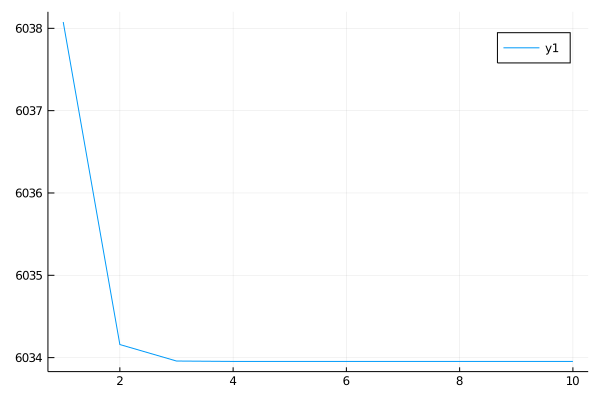

In [16]:
fevalues = reshape(fe, (iters, n))
plot(vec(sum(fevalues, dims = 2)))

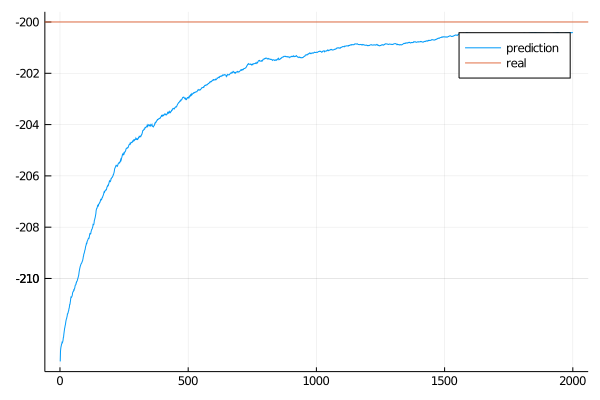

In [17]:
plot(ma[1:end], label = :prediction)
plot!([ realmean ], seriestype=:hline, label = :real)

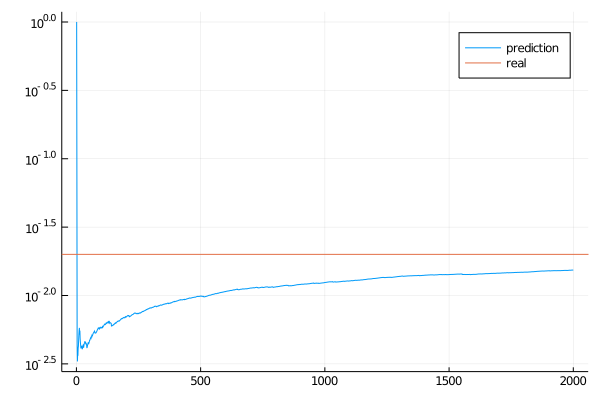

In [18]:
plot(pa[1:end], label = :prediction, yscale = :log10)
plot!([ realprecision ], seriestype=:hline, label = :real)